[View in Colaboratory](https://colab.research.google.com/github/tarosaku/sakutest/blob/master/stopsign_detection_test_new.ipynb)


Python2ならば動くが、Python3ではエラーになる　(2018.8.23時点)

##

(参考URL)

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_pets.md

https://www.petitmonte.com/python/ai_cup_ramen.html

https://qiita.com/watanabe0621/items/0b1cfa2d89c8321767e2

##

TensorFlowのインストールガイドに従って、環境構築を行う。

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

まずは、ライブラリのインストール

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython
!pip install --user contextlib2
!pip install --user jupyter
!pip install --user matplotlib
!pip install --user lxml


TensorFlow modelsのインストール

In [0]:
cd /content

In [0]:
!rm -r models
!git clone https://github.com/tensorflow/models.git

COCO APIのインストール

In [0]:
!rm -r cocoapi
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/models/research/

ライブラリをパスへ追加

In [0]:
%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

Protobufのコンパイル

In [0]:
cd /content/models/research

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

インストール完了テスト

In [0]:
!python object_detection/builders/model_builder_test.py

「OK」が出れば、環境構築完了

ここから、データやモデルの準備

画像データとannotationsデータをアップロード（ローカル or googleドライブから）

※annotationはlabelImgを使って行った

In [0]:
# images.tar.gz,annotations.tar.gzをローカルからアップロードする場合
# show upload dialog (images.tar.gz,annotations.tar.gzを選択)
from google.colab import files
uploaded = files.upload()

In [0]:
# images.zip,annotations.zipをgoogledriveから読み込む場合
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# images.zip,annotations.zipをgoogledriveから読み込む（続き）
id = '1kM4myEkQ_4ecFTGwaWda7csycVac0MKt'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('images.zip')
id = '1wtU9-m1AWyoChnYDVT8Cb2ovsTUA6oC-'  # 共有リンクで取得した id= より後の部分
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('annotations.zip')

アップロードしたデータを解凍

In [0]:
!unzip images.zip
!unzip annotations.zip

必要なファイルのアップロード

In [0]:
rm faster_rcnn_resnet101_stopsign*

In [0]:
#3ファイル（stopsign_label_map.pbtxt、create_tf_record.py、faster_rcnn_resnet101_stopsign.config）
from google.colab import files
uploaded = files.upload()

TFRecordの作成

In [0]:
!python create_tf_record.py \
    --annotations_dir=`pwd`/annotations \
    --images_dir=`pwd`/images \
    --output_dir=`pwd` \
    --label_map_path=stopsign_label_map.pbtxt

TFRecord作成の確認（train.recordとeval.recordができている）

In [0]:
!ls -l *record*

事前学習モデルのダウンロード

ここでは、faster_rcnn_resnet101_coco_11_06_2017を利用

In [0]:
!wget http://storage.googleapis.com/download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_11_06_2017.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_11_06_2017.tar.gz
!cp faster_rcnn_resnet101_coco_11_06_2017/model.ckpt.* .

TensorBoardの準備

In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

In [0]:
get_ipython().system_raw('tensorboard --logdir /content/models/research --host 0.0.0.0 --port 6006 &')
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


トレーニング用フォルダの作成

In [0]:
!mkdir train

トレーニングと評価

In [0]:
# python3対応
# object_detection_evaluation.pyのprintをpython3対応する修正が必要（括弧を追加）。ローカルで修正してアップする
# show upload dialog

#from google.colab import files
#uploaded = files.upload() #修正済のobject_detection_evaluation.pyをアップロード
#
#!mv object_detection_evaluation.py /content/models/research/object_detection/utils/object_detection_evaluation.py

In [0]:
# python3対応
# /content/models/research/object_detection/model_lib.pyの「itervalues」を「items」に置換。ローカルで修正してアップする
# show upload dialog

#from google.colab import files
#uploaded = files.upload() #修正済のmodel_lib.pyのをアップロード
#
#!mv model_lib.py /content/models/research/object_detection/model_lib.py

In [0]:
# エラーになる　何が悪いのか？　by sakurai 20180717
# python2ならば動いたが 10分程度経過するとwarningが出る by sakurai 20180720
# 「Ignoring detection with image id XXXX since it was previously added" & "Ignoring ground truth with image id XXXX since it was previously added"」
# 以下と同じ状況か？
# https://stackoverflow.com/questions/51407435/cloud-ml-engine-warning-message-on-object-detection-training-ignoring-ground-t/51419239
# 試しに下のパラメータを「--num_eval_steps=1101」にしたら、warningが消えて進み始めたみたい
#!python object_detection/model_main.py \
#    --pipeline_config_path=/content/models/research/faster_rcnn_resnet101_stopsign.config \
#    --model_dir=/content/models/research/train \
#    --num_train_steps=50000 \
#    --num_eval_steps=2000 \
#    --alsologtostderr

In [0]:
get_ipython().system_raw('python object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/faster_rcnn_resnet101_stopsign.config \
    --model_dir=/content/models/research/train \
    --num_train_steps=50000 \
    --num_eval_steps=100 \
    --alsologtostderr 2>&1 /content/log/tb.log &')

トレーニングが進んでいるかの確認。ファイルが増えていく。

（少し進むと、TensorBoardでも状況確認ができる）

In [0]:
!ls -l train

トレーニングのプロセスIDの確認

In [0]:
!ps -ef

トレーニングを打ち切る場合、object_detection/model_main.pyのプロセスをkillして終了させる

In [0]:
!kill 589 #model_main.pyをkillする

TensorFlowグラフのエクスポート

In [0]:
!rm -r  exported_graphs; mkdir exported_graphs

In [0]:
!cp train/model.ckpt-2450.* .

In [0]:
!export CHECKPOINT_NUMBER=2450; python object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path faster_rcnn_resnet101_stopsign.config \
    --trained_checkpoint_prefix train/model.ckpt-${CHECKPOINT_NUMBER} \
    --output_directory exported_graphs

エクスポートしたTensorFlowグラフをgoogleドライブに保存

In [0]:
!zip -r exp_g.zip exported_graphs

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'exp_g.zip'})
uploaded.SetContentFile('exp_g.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

ここまで確認済。

TensorFlowのチュートリアルを参考に、トレーニングしたモデルを使って推論を実行する

https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
#import tarfile
import tensorflow as tf
#import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
PATH_TO_CKPT = 'exported_graphs/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('', 'stopsign_label_map.pbtxt')

In [0]:
NUM_CLASSES = 1
    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
#試したい画像をアップする
from google.colab import files
uploaded = files.upload()

In [0]:
#アップした画像の名前を「image1.jpg」「image2.jpg」に変更する

!mv quick_safty_049.jpg object_detection/test_images/image1.jpg
!mv 19681100.jpg object_detection/test_images/image2.jpg

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

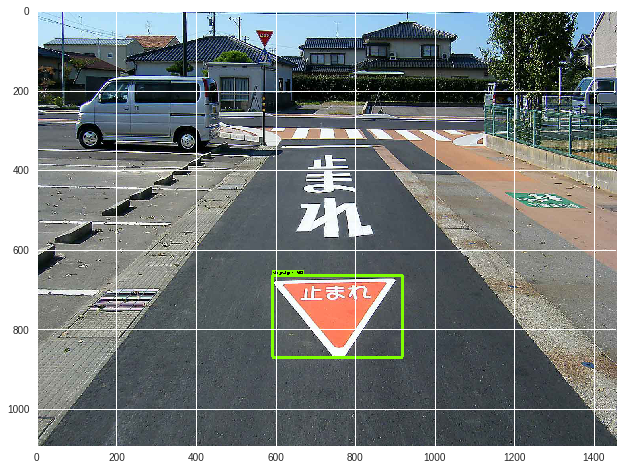

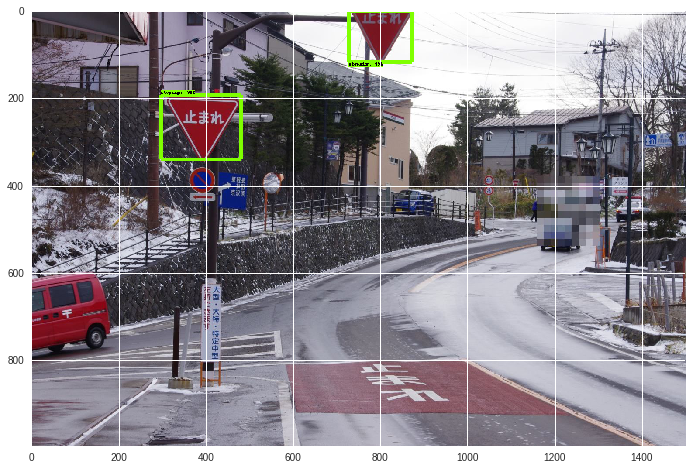

In [78]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)